<a href="https://colab.research.google.com/github/AhamedSulaiman/Fake-news/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk


# Machine Learning Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, accuracy_score,
                             confusion_matrix, roc_curve, roc_auc_score)


In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load the Dataset
df = pd.read_csv("fake_news_dataset.csv")

In [ ]:
# Display basic info
print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (20800, 5)
   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  


In [ ]:
df.isna().sum()

,0
id,0
title,558
author,1957
text,39
label,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [ ]:
print("Dataset shape:", df.shape)

Dataset shape: (18285, 5)


In [ ]:
df["content"]=df['title']+' '+df['author']

In [ ]:
# 1. Lowercase
df['lowercase'] = df['content'].str.lower()

In [ ]:
# 2. Tokenization
df['tokenized'] = df['lowercase'].apply(word_tokenize)

In [ ]:
# 3. Remove special characters (This step is now less critical but kept for structure)

def remove_non_alpha(tokens):
    return [re.sub(r'[^a-z]', '', w) for w in tokens if re.sub(r'[^a-z]', '', w) != '']
df['no_specials'] = df['tokenized'].apply(remove_non_alpha)


In [ ]:
# 4. Stopwords removal (Named function as you requested previously)
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]
df['no_stopwords'] = df['no_specials'].apply(remove_stopwords)

In [ ]:
# 5. Stemming (Simplified with Named Function)
stemmer = PorterStemmer()
def stem_tokens(tokens):
    return [stemmer.stem(w) for w in tokens]

df['stemmed'] = df['no_stopwords'].apply(stem_tokens)

In [ ]:
# 6. Lemmatization (Simplified with Named Function)
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(w) for w in tokens]

df['lemmatized'] = df['no_stopwords'].apply(lemmatize_tokens)

In [ ]:
df['processed_text'] = df['lemmatized'].apply(lambda x: ' '.join(x))

In [ ]:
df.head()

,id,title,author,text,label,content,lowercase,tokenized,no_specials,no_stopwords,stemmed,lemmatized,processed_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,house dem aide: we didn’t even see comey’s let...,"[house, dem, aide, :, we, didn, ’, t, even, se...","[house, dem, aide, we, didn, t, even, see, com...","[house, dem, aide, even, see, comey, letter, j...","[hous, dem, aid, even, see, comey, letter, jas...","[house, dem, aide, even, see, comey, letter, j...",house dem aide even see comey letter jason cha...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...","flynn: hillary clinton, big woman on campus - ...","[flynn, :, hillary, clinton, ,, big, woman, on...","[flynn, hillary, clinton, big, woman, on, camp...","[flynn, hillary, clinton, big, woman, campus, ...","[flynn, hillari, clinton, big, woman, campu, b...","[flynn, hillary, clinton, big, woman, campus, ...",flynn hillary clinton big woman campus breitba...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...,why the truth might get you fired consortiumne...,"[why, the, truth, might, get, you, fired, cons...","[why, the, truth, might, get, you, fired, cons...","[truth, might, get, fired, consortiumnewscom]","[truth, might, get, fire, consortiumnewscom]","[truth, might, get, fired, consortiumnewscom]",truth might get fired consortiumnewscom
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...,15 civilians killed in single us airstrike hav...,"[15, civilians, killed, in, single, us, airstr...","[civilians, killed, in, single, us, airstrike,...","[civilians, killed, single, us, airstrike, ide...","[civilian, kill, singl, us, airstrik, identifi...","[civilian, killed, single, u, airstrike, ident...",civilian killed single u airstrike identified ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...,iranian woman jailed for fictional unpublished...,"[iranian, woman, jailed, for, fictional, unpub...","[iranian, woman, jailed, for, fictional, unpub...","[iranian, woman, jailed, fictional, unpublishe...","[iranian, woman, jail, fiction, unpublish, sto...","[iranian, woman, jailed, fictional, unpublishe...",iranian woman jailed fictional unpublished sto...


In [ ]:
X=df['processed_text']
y=df['label']

In [ ]:
# Splitting the dataset to training & test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=2)

In [ ]:

# -------------------------------
# Bag of Words (BoW) approach
# -------------------------------
bow_vectorizer = CountVectorizer(max_features=5000)  # limit to top 5000 features
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# Train Logistic Regression
lr_bow = LogisticRegression(max_iter=500)
lr_bow.fit(X_train_bow, y_train)
y_pred_bow = lr_bow.predict(X_test_bow)

print("Bag of Words Results")
print("Accuracy:", accuracy_score(y_test, y_pred_bow))
print("Classification Report:\n", classification_report(y_test, y_pred_bow))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bow))

# -------------------------------
# TF-IDF approach
# -------------------------------
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Logistic Regression
lr_tfidf = LogisticRegression(max_iter=500)
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)

print("\nTF-IDF Results")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("Classification Report:\n", classification_report(y_test, y_pred_tfidf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tfidf))

Bag of Words Results
Accuracy: 0.9920700027344819
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      2072
           1       0.99      0.99      0.99      1585

    accuracy                           0.99      3657
   macro avg       0.99      0.99      0.99      3657
weighted avg       0.99      0.99      0.99      3657

Confusion Matrix:
 [[2051   21]
 [   8 1577]]

TF-IDF Results
Accuracy: 0.9830462127426852
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      2072
           1       0.97      0.99      0.98      1585

    accuracy                           0.98      3657
   macro avg       0.98      0.98      0.98      3657
weighted avg       0.98      0.98      0.98      3657

Confusion Matrix:
 [[2026   46]
 [  16 1569]]


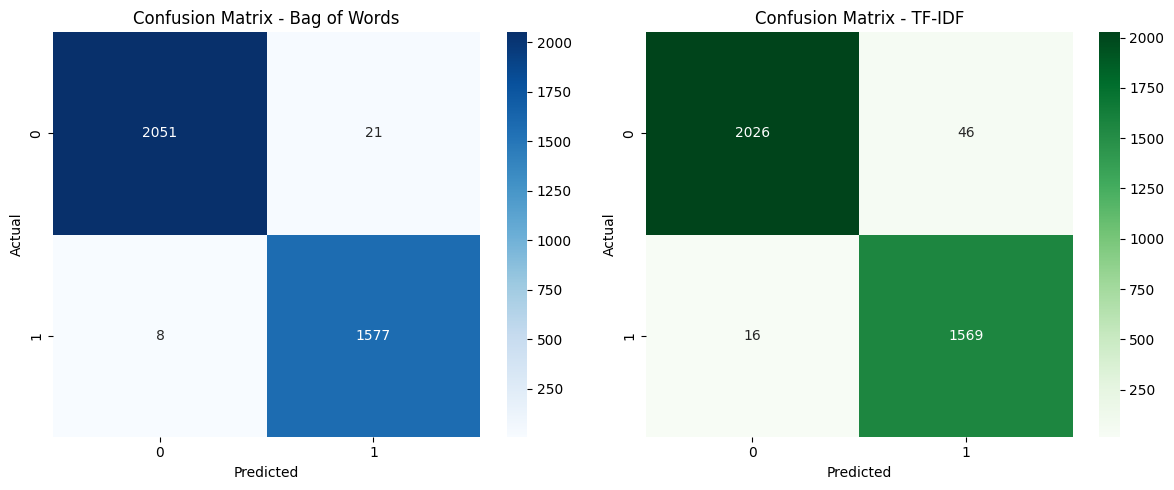

/tmp/ipython-input-1638913442.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Bag of Words', 'TF-IDF'], y=[bow_acc, tfidf_acc], palette='coolwarm')


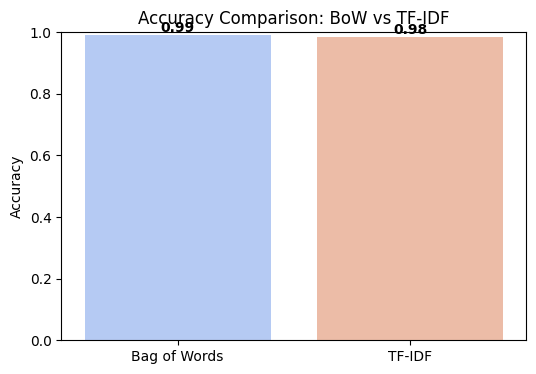

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Confusion Matrix Visualization (Side-by-Side)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred_bow), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Bag of Words')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_tfidf), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - TF-IDF')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# ✅ Accuracy Comparison (Bar Chart)
bow_acc = accuracy_score(y_test, y_pred_bow)
tfidf_acc = accuracy_score(y_test, y_pred_tfidf)

plt.figure(figsize=(6,4))
sns.barplot(x=['Bag of Words', 'TF-IDF'], y=[bow_acc, tfidf_acc], palette='coolwarm')
plt.title('Accuracy Comparison: BoW vs TF-IDF')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add text labels above bars
for i, v in enumerate([bow_acc, tfidf_acc]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10, fontweight='bold')

plt.show()
